# Q-learning or Q-network (QN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([-0.04449294, -0.21327739, -0.01225429,  0.26880974]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.570289819880813 -3.026688140247116


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return actions, states, targetQs

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [18]:
def model_loss(actions, states, targetQs, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    # loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits, 
    #                                                               labels=tf.nn.sigmoid(Qs_labels)))    
    return actions_logits, loss

In [19]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [21]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [22]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [23]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [24]:
# Training parameters
batch_size = 500               # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [25]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [26]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [27]:
state, reward, action

(array([ 0.05272068, -0.26944343,  0.07353636,  0.8886292 ]), 1.0, 0)

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    
    # Training episodes/epochs
    for ep in range(111111111111111):
        state = env.reset()
        total_reward = 0
        loss_batch = []

        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states}) 
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (0.99 * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        episodes_total_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'loss:{:.4f}'.format(np.mean(loss_batch)))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-qn.ckpt')

Episode:0 meanR:29.0000 loss:1.5087
Episode:1 meanR:19.5000 loss:1.9406
Episode:2 meanR:25.3333 loss:4.9186
Episode:3 meanR:24.0000 loss:30.0577
Episode:4 meanR:24.6000 loss:182.0217
Episode:5 meanR:26.3333 loss:942.8831
Episode:6 meanR:27.5714 loss:1078.2013
Episode:7 meanR:28.3750 loss:1046.4786
Episode:8 meanR:28.5556 loss:4776.6450
Episode:9 meanR:27.7000 loss:19666.2090
Episode:10 meanR:26.9091 loss:58615.6172
Episode:11 meanR:27.5833 loss:151073.7188
Episode:12 meanR:26.3077 loss:347713.0625
Episode:13 meanR:25.2857 loss:508659.7188
Episode:14 meanR:24.2000 loss:819122.0000
Episode:15 meanR:23.7500 loss:1150222.3750
Episode:16 meanR:23.8824 loss:1003401.6875
Episode:17 meanR:23.4444 loss:615355.3750
Episode:18 meanR:23.1053 loss:427991.7500
Episode:19 meanR:23.2000 loss:289963.1875
Episode:20 meanR:22.7143 loss:211147.8594
Episode:21 meanR:22.6818 loss:166758.6406
Episode:22 meanR:22.5652 loss:130900.0781
Episode:23 meanR:22.0000 loss:108322.1484
Episode:24 meanR:23.4800 loss:655

Episode:195 meanR:60.9500 loss:241786768.0000
Episode:196 meanR:62.0800 loss:224036736.0000
Episode:197 meanR:62.8300 loss:262583360.0000
Episode:198 meanR:64.2500 loss:269702880.0000
Episode:199 meanR:65.8500 loss:270262016.0000
Episode:200 meanR:67.2200 loss:299463520.0000
Episode:201 meanR:68.6700 loss:340469760.0000
Episode:202 meanR:69.3700 loss:364549472.0000
Episode:203 meanR:70.7000 loss:371376768.0000
Episode:204 meanR:72.1300 loss:383944928.0000
Episode:205 meanR:73.5400 loss:399730496.0000
Episode:206 meanR:75.2900 loss:383824128.0000
Episode:207 meanR:76.7400 loss:371764192.0000
Episode:208 meanR:76.3900 loss:367819648.0000
Episode:209 meanR:77.9900 loss:341518528.0000
Episode:210 meanR:79.4500 loss:356220992.0000
Episode:211 meanR:80.8700 loss:330579712.0000
Episode:212 meanR:82.5100 loss:345485536.0000
Episode:213 meanR:84.3100 loss:339575776.0000
Episode:214 meanR:85.0500 loss:369909344.0000
Episode:215 meanR:86.2700 loss:295321408.0000
Episode:216 meanR:87.6800 loss:310

Episode:370 meanR:182.7100 loss:319660480.0000
Episode:371 meanR:182.4000 loss:333055296.0000
Episode:372 meanR:182.3900 loss:353926464.0000
Episode:373 meanR:182.1600 loss:362285216.0000
Episode:374 meanR:182.0000 loss:365481248.0000
Episode:375 meanR:182.1100 loss:369215648.0000
Episode:376 meanR:182.2100 loss:367437120.0000
Episode:377 meanR:182.2200 loss:360275584.0000
Episode:378 meanR:182.3900 loss:352763552.0000
Episode:379 meanR:182.8600 loss:335400992.0000
Episode:380 meanR:182.8300 loss:324774240.0000
Episode:381 meanR:182.8900 loss:340145248.0000
Episode:382 meanR:182.8100 loss:360160064.0000
Episode:383 meanR:182.6600 loss:358778624.0000
Episode:384 meanR:182.6100 loss:361212704.0000
Episode:385 meanR:182.8400 loss:354576352.0000
Episode:386 meanR:182.5500 loss:363771392.0000
Episode:387 meanR:182.8100 loss:346212736.0000
Episode:388 meanR:182.7500 loss:351376032.0000
Episode:389 meanR:182.9000 loss:341621920.0000
Episode:390 meanR:183.0800 loss:347876928.0000
Episode:391 m

Episode:545 meanR:180.0000 loss:342360896.0000
Episode:546 meanR:179.7900 loss:348147488.0000
Episode:547 meanR:179.6000 loss:345707392.0000
Episode:548 meanR:179.8500 loss:342275488.0000
Episode:549 meanR:179.9100 loss:337673888.0000
Episode:550 meanR:179.7200 loss:332590848.0000
Episode:551 meanR:179.6300 loss:340722016.0000
Episode:552 meanR:179.7000 loss:338817728.0000
Episode:553 meanR:179.9300 loss:338308064.0000
Episode:554 meanR:179.8500 loss:334922336.0000
Episode:555 meanR:179.9500 loss:337876416.0000
Episode:556 meanR:180.0300 loss:334876928.0000
Episode:557 meanR:179.8500 loss:345190688.0000
Episode:558 meanR:179.8400 loss:348478688.0000
Episode:559 meanR:179.8300 loss:348099040.0000
Episode:560 meanR:179.4600 loss:343262112.0000
Episode:561 meanR:179.2500 loss:348376864.0000
Episode:562 meanR:179.1300 loss:364246464.0000
Episode:563 meanR:179.2200 loss:357566240.0000
Episode:564 meanR:179.2300 loss:350858528.0000
Episode:565 meanR:178.9300 loss:355779648.0000
Episode:566 m

Episode:720 meanR:180.7700 loss:362912416.0000
Episode:721 meanR:180.7600 loss:353916320.0000
Episode:722 meanR:180.6500 loss:336695456.0000
Episode:723 meanR:180.5000 loss:340029504.0000
Episode:724 meanR:180.5300 loss:358755168.0000
Episode:725 meanR:180.5500 loss:364222048.0000
Episode:726 meanR:180.8700 loss:341315808.0000
Episode:727 meanR:180.8000 loss:335992896.0000
Episode:728 meanR:180.7000 loss:337536992.0000
Episode:729 meanR:180.3800 loss:357887616.0000
Episode:730 meanR:180.3000 loss:355518848.0000
Episode:731 meanR:180.3000 loss:349980608.0000
Episode:732 meanR:180.3700 loss:356201088.0000
Episode:733 meanR:180.4300 loss:356430880.0000
Episode:734 meanR:180.5600 loss:348403648.0000
Episode:735 meanR:180.3500 loss:346857536.0000
Episode:736 meanR:180.0200 loss:345476672.0000
Episode:737 meanR:180.1900 loss:353357888.0000
Episode:738 meanR:180.1600 loss:342182336.0000
Episode:739 meanR:179.7100 loss:357234752.0000
Episode:740 meanR:179.6600 loss:369989440.0000
Episode:741 m

Episode:895 meanR:180.6000 loss:361260224.0000
Episode:896 meanR:180.7500 loss:352254848.0000
Episode:897 meanR:180.9500 loss:342004768.0000
Episode:898 meanR:181.0800 loss:323139552.0000
Episode:899 meanR:181.0000 loss:335724384.0000
Episode:900 meanR:180.9200 loss:354241984.0000
Episode:901 meanR:181.2000 loss:354946368.0000
Episode:902 meanR:180.8300 loss:358713984.0000
Episode:903 meanR:180.8400 loss:350907456.0000
Episode:904 meanR:180.9100 loss:350705536.0000
Episode:905 meanR:181.0400 loss:336922016.0000
Episode:906 meanR:180.9600 loss:350522592.0000
Episode:907 meanR:180.9200 loss:364486464.0000
Episode:908 meanR:180.5500 loss:376268000.0000
Episode:909 meanR:180.2700 loss:377998304.0000
Episode:910 meanR:180.3200 loss:364590496.0000
Episode:911 meanR:180.5300 loss:343783168.0000
Episode:912 meanR:180.4500 loss:340560192.0000
Episode:913 meanR:180.7400 loss:335348576.0000
Episode:914 meanR:180.7800 loss:346186816.0000
Episode:915 meanR:180.8100 loss:336893824.0000
Episode:916 m

Episode:1068 meanR:180.9100 loss:329578752.0000
Episode:1069 meanR:180.8500 loss:330559040.0000
Episode:1070 meanR:181.0100 loss:349360800.0000
Episode:1071 meanR:180.9900 loss:351352928.0000
Episode:1072 meanR:180.8700 loss:346877120.0000
Episode:1073 meanR:180.8500 loss:349074720.0000
Episode:1074 meanR:180.5000 loss:350059296.0000
Episode:1075 meanR:180.4400 loss:363439104.0000
Episode:1076 meanR:180.3300 loss:363117920.0000
Episode:1077 meanR:180.5800 loss:346054656.0000
Episode:1078 meanR:180.9200 loss:331342592.0000
Episode:1079 meanR:180.7300 loss:332214720.0000
Episode:1080 meanR:180.8100 loss:350219008.0000
Episode:1081 meanR:180.6100 loss:358469248.0000
Episode:1082 meanR:180.5300 loss:354442816.0000
Episode:1083 meanR:180.6700 loss:340971232.0000
Episode:1084 meanR:180.6300 loss:333710944.0000
Episode:1085 meanR:180.7500 loss:325706560.0000
Episode:1086 meanR:180.7500 loss:337208672.0000
Episode:1087 meanR:180.8900 loss:348014272.0000
Episode:1088 meanR:180.7400 loss:3551145

Episode:1239 meanR:182.0800 loss:350406432.0000
Episode:1240 meanR:181.8800 loss:360330976.0000
Episode:1241 meanR:182.2600 loss:343886560.0000
Episode:1242 meanR:182.3600 loss:334732576.0000
Episode:1243 meanR:182.1600 loss:339892608.0000
Episode:1244 meanR:182.1900 loss:363744352.0000
Episode:1245 meanR:182.2900 loss:345581984.0000
Episode:1246 meanR:182.0700 loss:328222912.0000
Episode:1247 meanR:181.6900 loss:332990720.0000
Episode:1248 meanR:181.6800 loss:342257088.0000
Episode:1249 meanR:181.9100 loss:332290624.0000
Episode:1250 meanR:181.9100 loss:323409888.0000
Episode:1251 meanR:182.0400 loss:342169344.0000
Episode:1252 meanR:181.9100 loss:362935584.0000
Episode:1253 meanR:181.9100 loss:360627136.0000
Episode:1254 meanR:182.1000 loss:347894240.0000
Episode:1255 meanR:182.0700 loss:333443168.0000
Episode:1256 meanR:181.7700 loss:337126656.0000
Episode:1257 meanR:181.9100 loss:343426432.0000
Episode:1258 meanR:181.8000 loss:352319936.0000
Episode:1259 meanR:181.6800 loss:3470734

Episode:1410 meanR:181.9600 loss:344993760.0000
Episode:1411 meanR:181.9500 loss:347666528.0000
Episode:1412 meanR:181.9700 loss:349447168.0000
Episode:1413 meanR:181.9500 loss:369373088.0000
Episode:1414 meanR:182.1200 loss:353489024.0000
Episode:1415 meanR:182.2800 loss:342486720.0000
Episode:1416 meanR:182.4400 loss:323916320.0000
Episode:1417 meanR:182.7000 loss:330897888.0000
Episode:1418 meanR:182.8500 loss:326532064.0000
Episode:1419 meanR:182.7000 loss:340482592.0000
Episode:1420 meanR:182.9500 loss:336548800.0000
Episode:1421 meanR:182.8800 loss:331427328.0000
Episode:1422 meanR:182.9900 loss:327126144.0000
Episode:1423 meanR:183.2000 loss:339920448.0000
Episode:1424 meanR:183.1400 loss:352929664.0000
Episode:1425 meanR:183.0100 loss:346233152.0000
Episode:1426 meanR:182.7000 loss:365604448.0000
Episode:1427 meanR:182.8100 loss:355281856.0000
Episode:1428 meanR:182.8500 loss:370088832.0000
Episode:1429 meanR:182.8400 loss:358549600.0000
Episode:1430 meanR:182.8100 loss:3540559

Episode:1581 meanR:189.6300 loss:341861024.0000
Episode:1582 meanR:189.8700 loss:358332736.0000
Episode:1583 meanR:189.6700 loss:366729056.0000
Episode:1584 meanR:189.3100 loss:377649600.0000
Episode:1585 meanR:189.2900 loss:391293824.0000
Episode:1586 meanR:189.4400 loss:379612640.0000
Episode:1587 meanR:189.7100 loss:355383168.0000
Episode:1588 meanR:189.6100 loss:354593536.0000
Episode:1589 meanR:189.3500 loss:367861376.0000
Episode:1590 meanR:189.3600 loss:387983424.0000
Episode:1591 meanR:189.4400 loss:372364512.0000
Episode:1592 meanR:189.3800 loss:357999872.0000
Episode:1593 meanR:189.3800 loss:349997248.0000
Episode:1594 meanR:189.2700 loss:367166848.0000
Episode:1595 meanR:189.2200 loss:381254656.0000
Episode:1596 meanR:189.2300 loss:378469728.0000
Episode:1597 meanR:188.8400 loss:381598496.0000
Episode:1598 meanR:189.1500 loss:361720544.0000
Episode:1599 meanR:189.1700 loss:368068992.0000
Episode:1600 meanR:188.9000 loss:364275360.0000
Episode:1601 meanR:189.2800 loss:3676536

Episode:1752 meanR:189.6900 loss:367660096.0000
Episode:1753 meanR:189.7500 loss:360968224.0000
Episode:1754 meanR:189.6300 loss:362666816.0000
Episode:1755 meanR:189.9400 loss:352057344.0000
Episode:1756 meanR:189.6500 loss:348504288.0000
Episode:1757 meanR:189.4900 loss:355801248.0000
Episode:1758 meanR:189.4700 loss:377752480.0000
Episode:1759 meanR:189.2600 loss:375163776.0000
Episode:1760 meanR:189.2800 loss:374018272.0000
Episode:1761 meanR:189.1600 loss:378102272.0000
Episode:1762 meanR:189.2800 loss:376033920.0000
Episode:1763 meanR:188.9600 loss:367487840.0000
Episode:1764 meanR:188.6600 loss:364133600.0000
Episode:1765 meanR:188.5100 loss:387677024.0000
Episode:1766 meanR:188.2100 loss:395101696.0000
Episode:1767 meanR:188.6000 loss:379680608.0000
Episode:1768 meanR:188.6900 loss:369599200.0000
Episode:1769 meanR:188.4300 loss:362193856.0000
Episode:1770 meanR:188.5100 loss:367106848.0000
Episode:1771 meanR:188.7200 loss:355572224.0000
Episode:1772 meanR:188.8600 loss:3514609

Episode:1923 meanR:188.6600 loss:377753376.0000
Episode:1924 meanR:188.5000 loss:380315328.0000
Episode:1925 meanR:188.5000 loss:380733152.0000
Episode:1926 meanR:188.2700 loss:385417216.0000
Episode:1927 meanR:188.3200 loss:381831968.0000
Episode:1928 meanR:188.1700 loss:379880320.0000
Episode:1929 meanR:188.4000 loss:367315648.0000
Episode:1930 meanR:188.4700 loss:360847552.0000
Episode:1931 meanR:188.1100 loss:348375232.0000
Episode:1932 meanR:188.7300 loss:328854720.0000
Episode:1933 meanR:188.8400 loss:323461856.0000
Episode:1934 meanR:188.7900 loss:343543040.0000
Episode:1935 meanR:188.7900 loss:391943424.0000
Episode:1936 meanR:188.6800 loss:389760704.0000
Episode:1937 meanR:188.5300 loss:381955424.0000
Episode:1938 meanR:188.5400 loss:373126880.0000
Episode:1939 meanR:188.6200 loss:371102336.0000
Episode:1940 meanR:188.4800 loss:378930208.0000
Episode:1941 meanR:188.6900 loss:366474048.0000
Episode:1942 meanR:188.6100 loss:344998400.0000
Episode:1943 meanR:189.1300 loss:3245105

Episode:2094 meanR:190.2500 loss:355283744.0000
Episode:2095 meanR:190.3800 loss:368146528.0000
Episode:2096 meanR:190.3100 loss:376058048.0000
Episode:2097 meanR:190.5200 loss:355777760.0000
Episode:2098 meanR:190.6400 loss:343448896.0000
Episode:2099 meanR:190.6300 loss:341697344.0000
Episode:2100 meanR:190.5500 loss:364219040.0000
Episode:2101 meanR:190.8100 loss:381200544.0000
Episode:2102 meanR:190.5500 loss:373326272.0000
Episode:2103 meanR:190.7800 loss:367026976.0000
Episode:2104 meanR:190.8900 loss:372989600.0000
Episode:2105 meanR:190.8100 loss:378381184.0000
Episode:2106 meanR:191.0900 loss:377042560.0000
Episode:2107 meanR:190.9700 loss:363558560.0000
Episode:2108 meanR:190.7400 loss:351082688.0000
Episode:2109 meanR:190.9300 loss:354201248.0000
Episode:2110 meanR:190.8600 loss:369528288.0000
Episode:2111 meanR:190.9200 loss:360628512.0000
Episode:2112 meanR:191.1500 loss:352623232.0000
Episode:2113 meanR:191.2300 loss:335970880.0000
Episode:2114 meanR:190.6300 loss:3598503

Episode:2265 meanR:193.1400 loss:356470272.0000
Episode:2266 meanR:193.2100 loss:360795776.0000
Episode:2267 meanR:193.0500 loss:353851808.0000
Episode:2268 meanR:192.8800 loss:365673600.0000
Episode:2269 meanR:193.1300 loss:362750624.0000
Episode:2270 meanR:193.2100 loss:366219520.0000
Episode:2271 meanR:192.9000 loss:352676960.0000
Episode:2272 meanR:192.5500 loss:362668768.0000
Episode:2273 meanR:192.2800 loss:365190496.0000
Episode:2274 meanR:192.2900 loss:373987936.0000
Episode:2275 meanR:192.5400 loss:361884256.0000
Episode:2276 meanR:192.1800 loss:349217568.0000
Episode:2277 meanR:192.4300 loss:344029024.0000
Episode:2278 meanR:192.2700 loss:353255520.0000
Episode:2279 meanR:192.2300 loss:348203168.0000
Episode:2280 meanR:191.6400 loss:360014688.0000
Episode:2281 meanR:191.5000 loss:370114912.0000
Episode:2282 meanR:191.4500 loss:372018304.0000
Episode:2283 meanR:191.4400 loss:354661760.0000
Episode:2284 meanR:191.7100 loss:350161152.0000
Episode:2285 meanR:191.5800 loss:3452324

Episode:2436 meanR:190.2900 loss:366972640.0000
Episode:2437 meanR:189.8600 loss:377005568.0000
Episode:2438 meanR:190.2600 loss:368526240.0000
Episode:2439 meanR:190.2800 loss:360097856.0000
Episode:2440 meanR:190.1600 loss:359328000.0000
Episode:2441 meanR:190.5400 loss:362773632.0000
Episode:2442 meanR:190.6200 loss:351777984.0000
Episode:2443 meanR:190.7200 loss:333212736.0000
Episode:2444 meanR:190.3900 loss:344309248.0000
Episode:2445 meanR:190.2300 loss:357382912.0000
Episode:2446 meanR:190.2000 loss:388674144.0000
Episode:2447 meanR:190.0300 loss:383164992.0000
Episode:2448 meanR:189.9800 loss:373397696.0000
Episode:2449 meanR:189.6000 loss:376306912.0000
Episode:2450 meanR:189.2300 loss:385407872.0000
Episode:2451 meanR:188.8700 loss:396641600.0000
Episode:2452 meanR:189.1300 loss:382446592.0000
Episode:2453 meanR:188.8900 loss:371728096.0000
Episode:2454 meanR:188.8900 loss:350823872.0000
Episode:2455 meanR:189.3900 loss:340760448.0000
Episode:2456 meanR:189.3000 loss:3371680

Episode:2607 meanR:189.4700 loss:380037984.0000
Episode:2608 meanR:189.8000 loss:359431648.0000
Episode:2609 meanR:189.7500 loss:358794592.0000
Episode:2610 meanR:189.6200 loss:354760320.0000
Episode:2611 meanR:189.4900 loss:374624384.0000
Episode:2612 meanR:189.7800 loss:366695552.0000
Episode:2613 meanR:189.5600 loss:358644896.0000
Episode:2614 meanR:189.3900 loss:349155072.0000
Episode:2615 meanR:189.3500 loss:361292288.0000
Episode:2616 meanR:189.1700 loss:368714592.0000
Episode:2617 meanR:189.2900 loss:377324960.0000
Episode:2618 meanR:188.9800 loss:377693312.0000
Episode:2619 meanR:189.4500 loss:363459360.0000
Episode:2620 meanR:189.2700 loss:344664608.0000
Episode:2621 meanR:189.2100 loss:324121024.0000
Episode:2622 meanR:188.9300 loss:336641728.0000
Episode:2623 meanR:188.9100 loss:359346144.0000
Episode:2624 meanR:189.1400 loss:370732608.0000
Episode:2625 meanR:189.1400 loss:353954496.0000
Episode:2626 meanR:189.1000 loss:342800032.0000
Episode:2627 meanR:188.9700 loss:3467893

Episode:2778 meanR:193.1700 loss:345754144.0000
Episode:2779 meanR:193.1600 loss:352212800.0000
Episode:2780 meanR:193.0900 loss:364067328.0000
Episode:2781 meanR:193.3400 loss:352764288.0000
Episode:2782 meanR:193.3300 loss:338145760.0000
Episode:2783 meanR:193.6100 loss:323155712.0000
Episode:2784 meanR:193.5500 loss:330427936.0000
Episode:2785 meanR:193.1500 loss:364706688.0000
Episode:2786 meanR:193.1600 loss:377062848.0000
Episode:2787 meanR:193.5400 loss:350824224.0000
Episode:2788 meanR:193.3700 loss:335442880.0000
Episode:2789 meanR:193.4500 loss:350846048.0000
Episode:2790 meanR:193.5000 loss:374632352.0000
Episode:2791 meanR:193.4300 loss:368550976.0000
Episode:2792 meanR:193.3600 loss:359817632.0000
Episode:2793 meanR:193.3300 loss:361446176.0000
Episode:2794 meanR:193.0700 loss:359159968.0000
Episode:2795 meanR:192.9800 loss:366477312.0000
Episode:2796 meanR:193.1800 loss:364670144.0000
Episode:2797 meanR:193.3700 loss:370140512.0000
Episode:2798 meanR:193.4900 loss:3644933

Episode:2949 meanR:192.6700 loss:364005216.0000
Episode:2950 meanR:193.0900 loss:342261408.0000
Episode:2951 meanR:193.1600 loss:332912896.0000
Episode:2952 meanR:192.9400 loss:359260448.0000
Episode:2953 meanR:192.5600 loss:372607808.0000
Episode:2954 meanR:192.7600 loss:356621920.0000
Episode:2955 meanR:192.5800 loss:349356288.0000
Episode:2956 meanR:192.8800 loss:333654272.0000
Episode:2957 meanR:192.9800 loss:344786560.0000
Episode:2958 meanR:193.2700 loss:343705312.0000
Episode:2959 meanR:192.9100 loss:363806272.0000
Episode:2960 meanR:192.7100 loss:369955328.0000
Episode:2961 meanR:192.7200 loss:375857056.0000
Episode:2962 meanR:192.8500 loss:370701792.0000
Episode:2963 meanR:193.0500 loss:343033664.0000
Episode:2964 meanR:193.2900 loss:335315840.0000
Episode:2965 meanR:193.3800 loss:330576192.0000
Episode:2966 meanR:193.2100 loss:352426048.0000
Episode:2967 meanR:193.1300 loss:370159424.0000
Episode:2968 meanR:193.0800 loss:369647328.0000
Episode:2969 meanR:193.0300 loss:3692071

Episode:3120 meanR:190.0500 loss:352596832.0000
Episode:3121 meanR:190.2500 loss:356532768.0000
Episode:3122 meanR:190.4100 loss:356059136.0000
Episode:3123 meanR:190.4400 loss:328250368.0000
Episode:3124 meanR:190.4300 loss:329347648.0000
Episode:3125 meanR:190.9000 loss:333600704.0000
Episode:3126 meanR:190.7400 loss:336889312.0000
Episode:3127 meanR:191.0300 loss:330039904.0000
Episode:3128 meanR:191.5400 loss:336583488.0000
Episode:3129 meanR:191.2700 loss:344543008.0000
Episode:3130 meanR:191.2700 loss:357206304.0000
Episode:3131 meanR:191.3600 loss:374353408.0000
Episode:3132 meanR:191.6600 loss:364631200.0000
Episode:3133 meanR:191.4100 loss:363741824.0000
Episode:3134 meanR:191.8000 loss:355911200.0000
Episode:3135 meanR:191.6400 loss:354235936.0000
Episode:3136 meanR:191.8900 loss:340289888.0000
Episode:3137 meanR:191.7300 loss:359506368.0000
Episode:3138 meanR:191.2800 loss:373666272.0000
Episode:3139 meanR:191.4700 loss:371974816.0000
Episode:3140 meanR:191.5600 loss:3632285

Episode:3291 meanR:190.8700 loss:348118720.0000
Episode:3292 meanR:190.4800 loss:369317504.0000
Episode:3293 meanR:190.5700 loss:365528512.0000
Episode:3294 meanR:190.5300 loss:380848320.0000
Episode:3295 meanR:190.6900 loss:372562464.0000
Episode:3296 meanR:190.9600 loss:363364416.0000
Episode:3297 meanR:191.0700 loss:345707296.0000
Episode:3298 meanR:190.9800 loss:346153472.0000
Episode:3299 meanR:191.0600 loss:362042304.0000
Episode:3300 meanR:191.0800 loss:375419392.0000
Episode:3301 meanR:191.1800 loss:372534112.0000
Episode:3302 meanR:191.2200 loss:375996832.0000
Episode:3303 meanR:191.0600 loss:377379328.0000
Episode:3304 meanR:190.8000 loss:382379584.0000
Episode:3305 meanR:190.5400 loss:379359872.0000
Episode:3306 meanR:190.8700 loss:365162848.0000
Episode:3307 meanR:190.7300 loss:356674592.0000
Episode:3308 meanR:191.0600 loss:348173376.0000
Episode:3309 meanR:191.5000 loss:344120832.0000
Episode:3310 meanR:191.6700 loss:335359488.0000
Episode:3311 meanR:191.6800 loss:3526204

Episode:3462 meanR:188.2400 loss:348075072.0000
Episode:3463 meanR:188.3700 loss:344455072.0000
Episode:3464 meanR:188.1600 loss:337712064.0000
Episode:3465 meanR:188.2200 loss:356928288.0000
Episode:3466 meanR:188.3300 loss:366158240.0000
Episode:3467 meanR:188.3500 loss:354506784.0000
Episode:3468 meanR:188.4800 loss:353435680.0000
Episode:3469 meanR:188.6400 loss:356626272.0000
Episode:3470 meanR:188.6500 loss:365847072.0000
Episode:3471 meanR:189.0400 loss:351991328.0000
Episode:3472 meanR:189.1500 loss:340903840.0000
Episode:3473 meanR:189.1400 loss:336011232.0000
Episode:3474 meanR:189.4800 loss:351894592.0000
Episode:3475 meanR:189.7300 loss:353142720.0000
Episode:3476 meanR:189.4800 loss:344377824.0000
Episode:3477 meanR:189.2700 loss:364882880.0000
Episode:3478 meanR:189.0800 loss:385697440.0000
Episode:3479 meanR:189.3100 loss:376924224.0000
Episode:3480 meanR:189.7200 loss:356542816.0000
Episode:3481 meanR:189.9600 loss:330228640.0000
Episode:3482 meanR:190.0300 loss:3221573

Episode:3633 meanR:192.0500 loss:352706208.0000
Episode:3634 meanR:192.1600 loss:334863264.0000
Episode:3635 meanR:192.4500 loss:335605824.0000
Episode:3636 meanR:191.9300 loss:339944160.0000
Episode:3637 meanR:191.8400 loss:359512736.0000
Episode:3638 meanR:192.0600 loss:359270912.0000
Episode:3639 meanR:191.7300 loss:347034720.0000
Episode:3640 meanR:191.4700 loss:359288992.0000
Episode:3641 meanR:191.3500 loss:368111744.0000
Episode:3642 meanR:191.2400 loss:371099904.0000
Episode:3643 meanR:191.2900 loss:377244096.0000
Episode:3644 meanR:191.5000 loss:369635488.0000
Episode:3645 meanR:190.9400 loss:368026784.0000
Episode:3646 meanR:190.9000 loss:365756384.0000
Episode:3647 meanR:190.8900 loss:387699168.0000
Episode:3648 meanR:190.8200 loss:375498848.0000
Episode:3649 meanR:190.8000 loss:377145760.0000
Episode:3650 meanR:190.8100 loss:375646848.0000
Episode:3651 meanR:190.6500 loss:383475776.0000
Episode:3652 meanR:190.7800 loss:380797664.0000
Episode:3653 meanR:190.7200 loss:3842925

Episode:3804 meanR:190.3000 loss:359455584.0000
Episode:3805 meanR:190.3200 loss:351030464.0000
Episode:3806 meanR:190.5200 loss:347860448.0000
Episode:3807 meanR:190.8400 loss:337009280.0000
Episode:3808 meanR:190.6500 loss:337058432.0000
Episode:3809 meanR:190.8900 loss:344762144.0000
Episode:3810 meanR:191.1000 loss:356642784.0000
Episode:3811 meanR:191.2600 loss:345788032.0000
Episode:3812 meanR:190.8500 loss:357738528.0000
Episode:3813 meanR:190.8700 loss:362728672.0000
Episode:3814 meanR:191.0500 loss:356991008.0000
Episode:3815 meanR:191.2900 loss:346933120.0000
Episode:3816 meanR:191.3600 loss:365092032.0000
Episode:3817 meanR:191.2000 loss:374419712.0000
Episode:3818 meanR:191.2400 loss:387658368.0000
Episode:3819 meanR:190.9400 loss:383426240.0000
Episode:3820 meanR:191.2700 loss:374915488.0000
Episode:3821 meanR:191.3500 loss:369619136.0000
Episode:3822 meanR:191.5600 loss:351553824.0000
Episode:3823 meanR:191.4300 loss:352508000.0000
Episode:3824 meanR:191.3600 loss:3509401

Episode:3975 meanR:192.4300 loss:317017312.0000
Episode:3976 meanR:192.1900 loss:331120704.0000
Episode:3977 meanR:192.7100 loss:343619520.0000
Episode:3978 meanR:193.0700 loss:345286528.0000
Episode:3979 meanR:193.1900 loss:327788640.0000
Episode:3980 meanR:193.0700 loss:355818784.0000
Episode:3981 meanR:192.7700 loss:374149920.0000
Episode:3982 meanR:192.3900 loss:376932480.0000
Episode:3983 meanR:192.2800 loss:371058624.0000
Episode:3984 meanR:192.7200 loss:364228320.0000
Episode:3985 meanR:192.5400 loss:355647456.0000
Episode:3986 meanR:192.7100 loss:354316480.0000
Episode:3987 meanR:192.7400 loss:358271840.0000
Episode:3988 meanR:192.7400 loss:347182656.0000
Episode:3989 meanR:192.4800 loss:352315712.0000
Episode:3990 meanR:192.1300 loss:366922944.0000
Episode:3991 meanR:192.6500 loss:360727520.0000
Episode:3992 meanR:192.7500 loss:334703712.0000
Episode:3993 meanR:192.9400 loss:316118464.0000
Episode:3994 meanR:192.9500 loss:332451328.0000
Episode:3995 meanR:193.0200 loss:3530624

Episode:4146 meanR:191.1700 loss:370826720.0000
Episode:4147 meanR:191.1400 loss:374769696.0000
Episode:4148 meanR:191.0800 loss:402896224.0000
Episode:4149 meanR:191.0500 loss:379264192.0000
Episode:4150 meanR:191.3400 loss:352982496.0000
Episode:4151 meanR:191.2200 loss:332085056.0000
Episode:4152 meanR:191.3500 loss:337841312.0000
Episode:4153 meanR:191.6700 loss:341054240.0000
Episode:4154 meanR:191.5200 loss:346288064.0000
Episode:4155 meanR:191.2000 loss:362697280.0000
Episode:4156 meanR:191.3800 loss:374959776.0000
Episode:4157 meanR:191.4200 loss:357001984.0000
Episode:4158 meanR:191.1800 loss:355144256.0000
Episode:4159 meanR:190.4700 loss:377093248.0000
Episode:4160 meanR:190.4500 loss:380963200.0000
Episode:4161 meanR:190.5900 loss:366120992.0000
Episode:4162 meanR:190.5000 loss:343446176.0000
Episode:4163 meanR:190.6000 loss:351512864.0000
Episode:4164 meanR:191.0100 loss:351243456.0000
Episode:4165 meanR:191.3800 loss:348050272.0000
Episode:4166 meanR:191.2700 loss:3403529

Episode:4317 meanR:189.5500 loss:360242688.0000
Episode:4318 meanR:190.1300 loss:351009664.0000
Episode:4319 meanR:190.6600 loss:327954720.0000
Episode:4320 meanR:190.8200 loss:318275232.0000
Episode:4321 meanR:190.7700 loss:334912576.0000
Episode:4322 meanR:190.6400 loss:360269504.0000
Episode:4323 meanR:190.9900 loss:359775968.0000
Episode:4324 meanR:191.0000 loss:352167040.0000
Episode:4325 meanR:191.2500 loss:330195488.0000
Episode:4326 meanR:191.6000 loss:326704576.0000
Episode:4327 meanR:191.6500 loss:326898048.0000
Episode:4328 meanR:191.9200 loss:345845120.0000
Episode:4329 meanR:191.4800 loss:362631296.0000
Episode:4330 meanR:191.6000 loss:362664000.0000
Episode:4331 meanR:191.1500 loss:377342688.0000
Episode:4332 meanR:191.4300 loss:364866208.0000
Episode:4333 meanR:191.3700 loss:368958016.0000
Episode:4334 meanR:191.8000 loss:356982656.0000
Episode:4335 meanR:191.8900 loss:362121920.0000
Episode:4336 meanR:191.8400 loss:358723744.0000
Episode:4337 meanR:192.0100 loss:3625089

Episode:4488 meanR:190.5900 loss:344616672.0000
Episode:4489 meanR:190.4600 loss:345754752.0000
Episode:4490 meanR:190.4800 loss:348727904.0000
Episode:4491 meanR:190.5500 loss:356671936.0000
Episode:4492 meanR:190.3200 loss:362613984.0000
Episode:4493 meanR:190.5500 loss:360903104.0000
Episode:4494 meanR:190.6300 loss:355557632.0000
Episode:4495 meanR:190.6500 loss:352794016.0000
Episode:4496 meanR:190.3100 loss:375457184.0000
Episode:4497 meanR:190.5000 loss:375201056.0000
Episode:4498 meanR:190.9600 loss:359744480.0000
Episode:4499 meanR:191.1800 loss:344234144.0000
Episode:4500 meanR:191.2200 loss:333232384.0000
Episode:4501 meanR:191.3500 loss:341706560.0000
Episode:4502 meanR:191.1500 loss:359280736.0000
Episode:4503 meanR:191.3100 loss:362650336.0000
Episode:4504 meanR:191.4700 loss:353515552.0000
Episode:4505 meanR:191.2900 loss:350364768.0000
Episode:4506 meanR:190.6700 loss:372943488.0000
Episode:4507 meanR:190.8900 loss:370915584.0000
Episode:4508 meanR:191.3400 loss:3428894

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

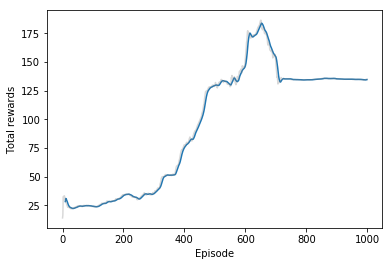

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

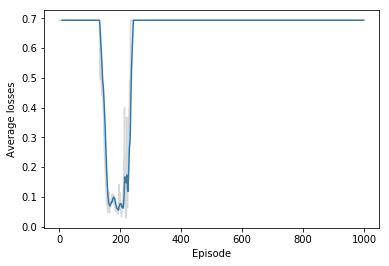

In [48]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [49]:
import gym
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {:.2f}'.format(total_reward))
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.00


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.